In [70]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

def nice_df(df, axis=None, reverse=False, **kwargs):
    cm = sns.light_palette("green", as_cmap=True, reverse=reverse)
    return df.style.background_gradient(cmap=cm, axis=axis, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
%load_ext autoreload
%autoreload 2

from GolfEnv import GolfEnv8d1p
from utils import QNetwork, QNetworkSequential, MinimumExponentialLR, EpsilonGreedy, train_naive_agent, get_episode_len

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


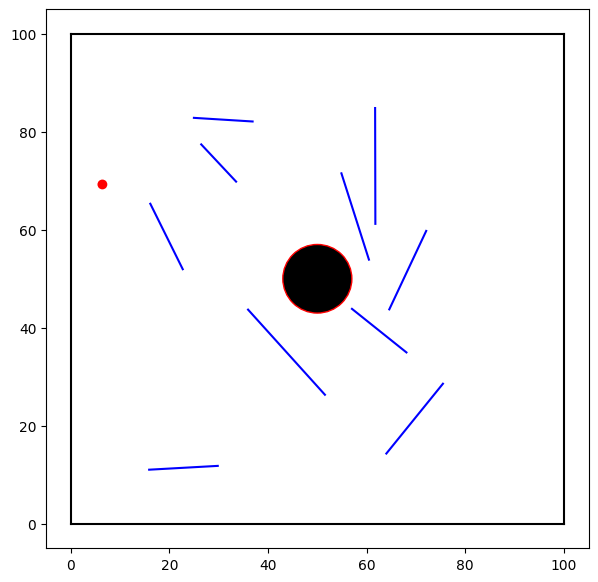

In [50]:
from GolfField import Ball, Point

reward_worse_better = lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100

env = GolfEnv8d1p(0, 10, reward_worse_better)
env.field.hole = Ball(Point(50, 50), 7)

env.render()

In [75]:
def get_score(model, num_train_episodes=1000, num_test_episodes=500, name='model'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()
    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=model)

    episode_reward_list = train_naive_agent(env,
                                            model,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=num_train_episodes,
                                            gamma=0.9)
    
    lens = np.array([get_episode_len(env, model, epsilon_greedy) for i in tqdm(range(num_test_episodes))])
    mean_len = np.mean(lens)
    suc_rate = np.mean(lens < 99)
    print(f'{name} suc rate: {suc_rate:.3f} | mean len: {mean_len:.3f}')

    return suc_rate, mean_len


In [127]:
layers_list = [
    [16],
    [32],
    [64],
    [128],
    [16, 16],
    [32, 32],
    [64, 64],
    [128, 128],
    [16, 16, 16],
    [32, 32, 32],
    [64, 64, 64],
    [128, 128, 128],
]

naive_trains_result_df_3 = pd.DataFrame(
    np.zeros((len(layers_list), 2)),
    index = [str(layers) for layers in layers_list],
    columns=["suc_rate", "mean_len"], 
)

networks_2 = list()
for layers in tqdm(layers_list):
    q_network = QNetworkSequential(2, 8, layers=layers).to(device)
    suc_rate, mean_len = get_score(q_network, num_train_episodes=2000, num_test_episodes=500, name=str(layers))
    naive_trains_result_df_3.loc[str(layers), ["suc_rate", "mean_len"]] = [suc_rate, 0]
    networks_2.append(q_network)
    


  8%|▊         | 1/12 [03:04<33:53, 184.87s/it]

[16] suc rate: 0.104 | mean len: 89.972


 17%|█▋        | 2/12 [05:58<29:45, 178.51s/it]

[32] suc rate: 0.292 | mean len: 76.178


 25%|██▌       | 3/12 [08:57<26:44, 178.31s/it]

[64] suc rate: 0.188 | mean len: 82.768


 33%|███▎      | 4/12 [12:08<24:28, 183.53s/it]

[128] suc rate: 0.168 | mean len: 84.934


 42%|████▏     | 5/12 [15:58<23:21, 200.17s/it]

[16, 16] suc rate: 0.190 | mean len: 81.916


 50%|█████     | 6/12 [19:07<19:39, 196.63s/it]

[32, 32] suc rate: 0.176 | mean len: 83.958


 58%|█████▊    | 7/12 [22:19<16:14, 194.97s/it]

[64, 64] suc rate: 0.196 | mean len: 82.604


 67%|██████▋   | 8/12 [25:33<12:58, 194.67s/it]

[128, 128] suc rate: 0.200 | mean len: 81.712


 75%|███████▌  | 9/12 [29:22<10:15, 205.28s/it]

[16, 16, 16] suc rate: 0.204 | mean len: 80.986


 83%|████████▎ | 10/12 [33:13<07:06, 213.25s/it]

[32, 32, 32] suc rate: 0.404 | mean len: 70.830


 92%|█████████▏| 11/12 [36:45<03:33, 213.05s/it]

[64, 64, 64] suc rate: 0.342 | mean len: 74.756


100%|██████████| 12/12 [40:36<00:00, 203.08s/it]

[128, 128, 128] suc rate: 0.978 | mean len: 35.374


In [128]:
nice_df(naive_trains_result_df_3, axis=0, reverse=False)


,suc_rate,mean_len
[16],0.104000,0.000000
[32],0.292000,0.000000
[64],0.188000,0.000000
[128],0.168000,0.000000
"[16, 16]",0.190000,0.000000
"[32, 32]",0.176000,0.000000
"[64, 64]",0.196000,0.000000
"[128, 128]",0.200000,0.000000
"[16, 16, 16]",0.204000,0.000000
"[32, 32, 32]",0.404000,0.000000


In [126]:
nice_df(naive_trains_result_df_2, axis=0, reverse=False)


,suc_rate,mean_len
[16],0.256000,0.000000
[32],0.570000,0.000000
[64],0.204000,0.000000
[128],0.490000,0.000000
"[16, 16]",0.568000,0.000000
"[32, 32]",0.072000,0.000000
"[64, 64]",0.042000,0.000000
"[128, 128]",0.544000,0.000000
"[16, 16, 16]",0.426000,0.000000
"[32, 32, 32]",0.396000,0.000000


In [123]:
nice_df(naive_trains_result_df, axis=0, reverse=False)


,suc_rate,mean_len
[16],0.508000,0.000000
[32],0.598000,0.000000
[64],0.584000,0.000000
[128],0.496000,0.000000
"[16, 16]",0.074000,0.000000
"[32, 32]",0.280000,0.000000
"[64, 64]",0.476000,0.000000
"[128, 128]",0.312000,0.000000
"[16, 16, 16]",0.294000,0.000000
"[32, 32, 32]",0.198000,0.000000


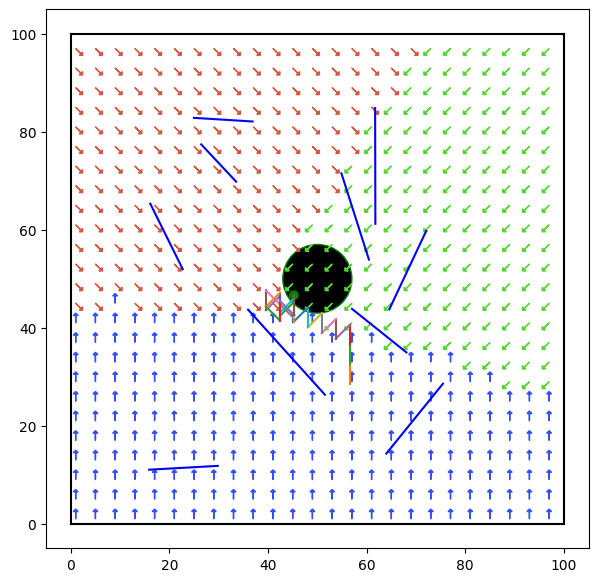

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 7))


func_for_action = lambda x, y: (20 + np.random.rand() * 130, 0.5)
func_for_action = lambda x, y: (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() * (360 / 8), 1)

func_for_action(40, 30)
env.render_wind(func_for_action, ax)

